# DPlis

While differentially private training methods offer strong privacy guarantees, they often result in lower model performance compared to non-private training. Additionally, these methods can lead to significant performance variability across different training runs. To address these issues, the authors propose a new approach called DPlis (Differentially Private Learning with Smoothing). DPlis introduces a smooth loss function that encourages the creation of robust models within flat regions of the loss landscape. 

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00233/CNAE-9.data

--2023-11-05 17:44:19--  https://archive.ics.uci.edu/ml/machine-learning-databases/00233/CNAE-9.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘CNAE-9.data.5’

CNAE-9.data.5           [              <=>   ]   1.76M   564KB/s    in 3.2s    

2023-11-05 17:44:23 (564 KB/s) - ‘CNAE-9.data.5’ saved [1851120]



In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset
import random
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from aijack.defense import GeneralMomentAccountant
from aijack.defense.dp.manager.dp_manager import DPSGDManager, AdaDPSManager

lot_size = 1
batch_size = 1
iterations = 100
sigma = 1.0
l2_norm_clip = 1
delta = 1e-3
lr = 0.01
criterion = nn.CrossEntropyLoss()

num_trials = 10

torch.manual_seed(42)
random.seed(42)
plt.style.use("ggplot")

In [3]:
df = pd.read_csv("CNAE-9.data", header=None)
X = df[range(1, df.shape[1])].values
y = df[[0]].values.reshape(-1) - 1

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_pub, y_train, y_pub = train_test_split(
    X_train, y_train, test_size=0.4, random_state=42
)

X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
X_pub = torch.Tensor(X_pub)
y_train = torch.Tensor(y_train).to(torch.long)
y_test = torch.Tensor(y_test).to(torch.long)
y_pub = torch.Tensor(y_pub).to(torch.long)

trainset = TensorDataset(X_train, y_train)

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(df.shape[1] - 1, 9)

    def forward(self, x):
        out = self.fc1(x)
        return out

In [5]:
def evaluate_dpoptimizer(accountant, privacy_manager, k=1):
    accountant.reset_step_info()
    accountant.add_step_info(
        {"sigma": sigma},
        lot_size / len(trainset),
        iterations * (len(trainset) / lot_size),
    )
    estimated_epsilon = accountant.get_epsilon(delta=delta)
    print(f"estimated epsilon is {estimated_epsilon}")

    accountant.reset_step_info()
    dpoptimizer_cls, lot_loader, batch_loader = privacy_manager.privatize(
        noise_multiplier=sigma
    )

    net = Net()
    optimizer = dpoptimizer_cls(net.parameters(), lr=lr)

    res = []
    for epoch in tqdm(range(iterations)):  # loop over the dataset multiple times
        for X_lot, y_lot in lot_loader(optimizer):
            for _ in range(k):
                for X_batch, y_batch in batch_loader(TensorDataset(X_lot, y_lot)):
                    optimizer.zero_grad()
                    loss = criterion(net(X_batch), y_batch) / k
                    loss.backward()
                    optimizer.step()
        res.append(criterion(net(X_test), y_test).item())

    return res

In [6]:
res1 = []

for _ in range(num_trials):
    accountant = GeneralMomentAccountant(
        noise_type="Gaussian",
        backend="cpp",
    )

    privacy_manager = DPSGDManager(
        accountant,
        optim.SGD,
        l2_norm_clip=l2_norm_clip,
        dataset=trainset,
        lot_size=lot_size,
        batch_size=batch_size,
        iterations=iterations,
    )

    res1.append(evaluate_dpoptimizer(accountant, privacy_manager))

estimated epsilon is 1.8524497289713917


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.28it/s]


estimated epsilon is 1.8524497289713917


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.04it/s]


estimated epsilon is 1.8524497289713917


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.85it/s]


estimated epsilon is 1.8524497289713917


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.19it/s]


estimated epsilon is 1.8524497289713917


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.58it/s]


estimated epsilon is 1.8524497289713917


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.22it/s]


estimated epsilon is 1.8524497289713917


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.17it/s]


estimated epsilon is 1.8524497289713917


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.74it/s]


estimated epsilon is 1.8524497289713917


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.89it/s]


estimated epsilon is 1.8524497289713917


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.11it/s]


In [7]:
res2 = []

for _ in range(1): 
    accountant = GeneralMomentAccountant(
        noise_type="Gaussian",
        backend="cpp",
    )

    privacy_manager = DPSGDManager(
        accountant,
        optim.SGD,
        l2_norm_clip=l2_norm_clip,
        dataset=trainset,
        lot_size=lot_size,
        batch_size=batch_size,
        iterations=iterations,
        smoothing=True,
        smoothing_radius=0.1,
    )

    res2.append(evaluate_dpoptimizer(accountant, privacy_manager, k=10))

estimated epsilon is 1.8524497289713917


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [01:57<00:00,  1.17s/it]


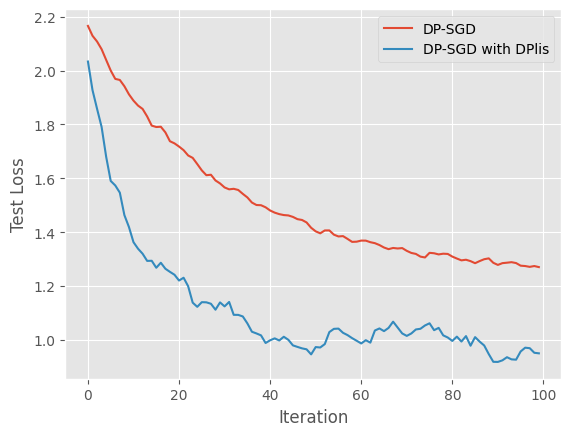

In [8]:
plt.plot(np.array(res1).mean(axis=0), label="DP-SGD")
plt.plot(np.array(res2).mean(axis=0), label="DP-SGD with DPlis")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Test Loss")
plt.show()